In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r drive/MyDrive/dataset.zip . 

In [ ]:
!unzip -qq dataset.zip

In [ ]:
!pip install -q segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.5 MB/s eta 0:00:00


In [ ]:
# imports & constants needed
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm
tqdm.pandas()
import gc
import copy
from collections import defaultdict, OrderedDict
import torch.optim as optim
import pickle
from torchsummary import summary

# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SIZE = (224, 224)
BATCH_SIZE = 16

In [ ]:
# set seed
seed = 7
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
# load from file training, validation and test dataframes
df_train = pd.read_csv('uw-madison-gi-tract-image-segmentation/datasets/train.csv', sep='\t')
df_test = pd.read_csv('uw-madison-gi-tract-image-segmentation/datasets/test.csv', sep='\t')
df_val = pd.read_csv('uw-madison-gi-tract-image-segmentation/datasets/validation.csv', sep='\t')

df_train = df_train.fillna('')
df_test = df_test.fillna('')
df_val = df_val.fillna('')
df_train.head()

,id,large_bowel,small_bowel,stomach,path,width,height,organ
0,case124_day20_slice_0081,28568 5 28833 7 29098 9 29363 10 29629 10 2989...,33943 7 34168 3 34208 11 34433 4 34473 13 3469...,28088 11 28353 14 28617 17 28882 19 29148 20 2...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,stomach_small_bowel_large_bowel
1,case9_day0_slice_0086,22451 1 22804 10 22827 10 23163 12 23185 13 23...,27877 5 28236 7 28595 11 28955 11 29315 11 296...,,uw-madison-gi-tract-image-segmentation/train/c...,360,310,small_bowel_large_bowel
2,case9_day22_slice_0077,20285 1 20626 10 20644 4 20985 12 21003 5 2103...,49066 3 49425 6 49784 9 50144 10 50504 11 5086...,,uw-madison-gi-tract-image-segmentation/train/c...,360,310,small_bowel_large_bowel
3,case115_day0_slice_0098,11569 8 11831 15 11853 5 12094 21 12118 13 123...,17477 2 17720 2 17728 9 17741 6 17977 2 17983 ...,,uw-madison-gi-tract-image-segmentation/train/c...,266,266,small_bowel_large_bowel
4,case54_day39_slice_0069,26030 4 26294 8 26560 9 26825 10 27091 10 2735...,,17719 14 17983 18 18249 20 18514 23 18779 26 1...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,stomach_large_bowel


In [ ]:
# utility function to get a mask given a RLE encoding and a shape
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts = []
    lengths = []
    ends = []

    for i in range(0, len(s), 2):
      start_pixel = int(s[i])-1;
      starts.append(start_pixel)
      lengths.append(int(s[i+1]))
      ends.append(start_pixel + int(s[i+1]))

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape)  

# utility function to encode a mask into RLE representation
def rle_encode(img):
    pixels = img.flatten()

    starting_point = 0;
    encoding = ''
    for i in range(0, len(pixels)):
      if (i == 0 and pixels[i] == 1) or (pixels[i-1] == 0 and pixels[i] == 1):
        starting_point = i;
        encoding += ' ' + str(starting_point + 1);

      if (pixels[i-1] == 1 and pixels[i] == 0) or (i == len(pixels) - 1 and pixels[i] == 1):
        encoding += ' ' + str(i - starting_point)

    return encoding;

# shows an image and the masks for large bowel, small bowel, stomach, with legend for clarity
def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, df, subset="train", transforms=None):
    self.df = df
    self.subset = subset
    self.transforms = transforms

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    # create a 3-tensor for the masks of the 3 organs
    masks = np.zeros((3, SIZE[0], SIZE[1]), dtype=np.float32)
    img_path=self.df['path'].iloc[index]
    width=self.df['width'].iloc[index]
    height=self.df['height'].iloc[index]
    # get image from disk
    img = self.__load_img(img_path)

    masks_list = []
    for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
      # take the encoded RLE mask of a certain index and organ
      encoded_mask = self.df[j].iloc[index]
      mask = rle_decode(encoded_mask, shape=(height, width, 1))
      mask = cv2.resize(mask, SIZE)
      # append mask to mask list
      masks_list.append(np.array(mask))
        
    # apply augmentations to both images and masks
    transformed = self.transforms(image=np.array(img), masks=masks_list)
    img = transformed["image"]
    masks_list = transformed["masks"]

    # create a 3-tensor for the masks, then transpose for pytorch format
    masks[0, :, :] = masks_list[0]
    masks[1, :, :] = masks_list[1]
    masks[2, :, :] = masks_list[2]
    img = img.transpose(2, 0, 1)

    return torch.tensor(img).to(device), torch.tensor(masks).to(device)

  def __load_img(self, img_path):
    # read gray-scale, 16-bit image with 1 channel (unchanged)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    # min-max normalization with min=0, max=255, and type unsigned 8-bit integer
    norm = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # resize to desired dimension
    img = cv2.resize(norm, SIZE)
    # replicate the image in depth 3 times -> [1 (width), 1 (height), 3 (depth)]
    # to get RGB
    img = np.tile(img[:, :, None], [1, 1, 3])

    return img

In [ ]:
data_transforms = {
    "train": A.Compose([
      # CLAHE is always applied to enhance contrast
      A.CLAHE(clip_limit=2.0, always_apply=True),
      # 3% max shift, 20 degrees max rotation, border is filled with black pixels
      A.ShiftScaleRotate(shift_limit=0.03, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.85), 
      # add small amount of gaussian noise, some blur
      A.OneOf([
                A.GaussNoise(var_limit=(0.0001, 0.004), p=0.7),
                A.Blur(blur_limit=3, p=0.3)
            ], p=0.5),      
      # vertical or horizontal flip
      A.Flip(p=0.5)
    ]),
    # CLAHE is always applied to enhance contrast
    "test": A.Compose([A.CLAHE(clip_limit=2.0, always_apply=True)])
}

In [ ]:
# get the possible organ labels in the training dataframe
# (e.g.: stomach, stomach_large_bowel, small_bowel_large_bowel, ...) 
classes = np.unique(df_train['organ'])
# count occurrences for all the classes
class_sample_count = np.array([len(np.where(df_train['organ'] == t)[0]) for t in classes])
# compute class weights, inversely proportional to class occurrence for batch balancing
class_weight = 1. / class_sample_count

weights = []
# assign class weights to each training sample in the training dataframe
for i in range(len(df_train['organ'])):
  label = df_train['organ'].iloc[i]
  idx = np.where(classes == label)[0]
  weights.append(class_weight[idx][0])

# print some weights for weighted random sampler
weights[0:10]

[0.0003856536829926726,
 0.00015867978419549348,
 0.00015867978419549348,
 0.00015867978419549348,
 0.00041425020712510354,
 0.0003856536829926726,
 0.0003856536829926726,
 0.00015867978419549348,
 0.00015867978419549348,
 0.00015867978419549348]

In [ ]:
# load train dataframe as custom dataset, applying 'train' augmentations
train_dataset = CustomDataset(df_train, subset="train", transforms=data_transforms['train'])
# load validation dataframe as custom dataset, applying 'test' augmentations
valid_dataset = CustomDataset(df_val, subset="validation", transforms=data_transforms['test'])
# init weighted random sampler for batch balancing
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), len(df_train))

# load dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=False, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# load dice and binary cross entropy losses
dice_loss = smp.losses.DiceLoss(mode='multilabel')
bce_loss = smp.losses.SoftBCEWithLogitsLoss()

# compound loss
def compound_loss_function(y_pred, groundtruth):
  return 0.4*dice_loss(y_pred, groundtruth) + 0.6*bce_loss(y_pred, groundtruth)

In [ ]:
# project float pixel predictions from [0, 1] to {0, 1}, then compute dice with formula
def dice_coefficient(groundtruth, y_pred, thr=0.5, epsilon=0.001):
    groundtruth = groundtruth.to(torch.float32)

    # round elements of y_pred
    y_pred = (y_pred>thr).to(torch.float32)

    # dimensions (NxCxWxH)
    # N: images' index in a batch
    # C: depth (channel)
    # W: width
    # H: height

    # (groundtruth AND prediction) of each layer of the mask torch tensor 
    # cardinality of the intersection
    intersection = (groundtruth*y_pred).sum(dim=(2,3))
    denominator = groundtruth.sum(dim=(2,3)) + y_pred.sum(dim=(2,3))
    dice = ((2*intersection+epsilon)/(denominator+epsilon)).mean(dim=(1,0))
    return dice


In [ ]:
# when using mixed-precision training it's important to be careful about the range of values 
# that the lower-precision numbers can represent, as very small or very large gradients 
# can lead to numerical instability and loss of precision. 
# The gradient scaler addresses this issue by automatically 
# rescaling the gradients during backpropagation, 
# so that they fall within a safe numerical range.

def train_one_epoch(model, optimizer, scheduler, dataloader, epoch):
    # set training mode
    model.train()
    # gradient scaler
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0

    score_values = []

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    
    for i, (images, masks) in progress_bar:      
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        y_pred = 0
        with amp.autocast(enabled=True):
            # get predicted value, forward pass
            y_pred = model(images)
            # compute the loss
            loss = compound_loss_function(y_pred, masks)
            
        # backpropagation 
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        # step optimizer with the scaler
        scaler.step(optimizer)
        scaler.update()
        
        # zero the gradient
        optimizer.zero_grad()
        scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size
        
        # take the current learning rate
        current_learning_rate = optimizer.param_groups[0]['lr']
        progress_bar.set_postfix(train_loss=f'{epoch_loss:0.5f}',
                        lr=f'{current_learning_rate:0.7f}')

        # put prediction in [0,1]
        y_pred = nn.Sigmoid()(y_pred) 
        # from torch tensor to numpy value
        dice = dice_coefficient(masks, y_pred).cpu().detach().numpy()
        score_values.append(dice)

        del images, masks, y_pred, loss

    epoch_mean_dice  = np.mean(score_values, axis=0)
    return epoch_loss, epoch_mean_dice

In [ ]:
# disable autograd as we do not need to backpropagate during validation
@torch.no_grad()
def valid_one_epoch(model, dataloader, epoch):
    # set test mode to disable dropout and prepare batch normalization layers
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    score_values = []
    
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for i, (images, masks) in progress_bar:   
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # get predicted value, forward pass
        y_pred = model(images)
        # compute the loss
        loss = compound_loss_function(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size
        
        # put prediction in [0,1]
        y_pred = nn.Sigmoid()(y_pred) 
        # from torch tensor to numpy value
        dice = dice_coefficient(masks, y_pred).cpu().detach().numpy()
        score_values.append(dice)
        del images, masks, y_pred, loss
        gc.collect()
        torch.cuda.empty_cache()
        
        progress_bar.set_postfix(valid_loss=f'{epoch_loss:0.4f}')

    # calculate mean dice coefficient values for batches
    epoch_mean_dice = np.mean(score_values, axis=0)   
    return epoch_loss, epoch_mean_dice

In [ ]:
def run_training(model, optimizer, scheduler, num_epochs):
    best_model_parameters = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        print(f'Epoch {epoch} - {num_epochs}', end='')
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()  
        torch.cuda.empty_cache()

        train_loss, train_mean_dice = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, epoch=epoch)
        
        validation_loss, validation_mean_dice = valid_one_epoch(model, valid_loader, epoch=epoch)
    
        history['Train Loss'].append(train_loss)
        history['Validation Loss'].append(validation_loss)
        history['Validation Dice'].append(validation_mean_dice)
        
        print(f'Validation Dice: {validation_mean_dice:0.4f}')
        
        # Save the best model during the training
        if validation_mean_dice >= best_dice:
            best_dice = validation_mean_dice
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "best_model.bin"
            torch.save(model.state_dict(), PATH)            
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

The encoder is composed of a series of convolutional and pooling layers that gradually reduce the resolution of the input image, extracting increasingly abstract and high-level information.

In particular, we have the following downsampling step:
- 3 -> 64
- 64 -> 128
- 128 -> 256
- 256 -> 512

At the end of the encoder, the input image is represented as a series of feature maps with high-level information.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        # input layer
        self.input_layer_dict = OrderedDict([
          ('conv', nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3)),
          ('maxpool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
          ('relu', nn.ReLU())
        ]) 
        nn.init.xavier_uniform_(self.input_layer_dict['conv'].weight)
        self.input_layer = nn.Sequential(self.input_layer_dict)     

        # layer 1
        self.layer1_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool1_2 = nn.MaxPool2d((2, 2))

        # layer 2
        self.layer2_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.maxpool2_2 = nn.MaxPool2d((2, 2))

        # layer 3
        self.layer3_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.maxpool3_2 = nn.MaxPool2d((2, 2))

    def forward(self, input):
        input = self.input_layer(input)
        input = self.layer1_1(input)
        input = self.maxpool1_2(input)
        input = self.layer2_1(input)
        input = self.maxpool2_2(input)
        input = self.layer3_1(input)
        input = self.maxpool3_2(input)
        return input

The decoder takes as input the low-resolution feature maps produced by the encoder and processes them through a series of convolutional and upsampling layers to produce a segmentation map with the same resolution as the input image.

In particular, we have the following downsampling step:
- 512 -> 256
- 256 -> 128
- 128 -> 64
- 64 -> 3

In [ ]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.layer1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)
        self.layer2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.layer3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        self.output_layer = nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2, padding=0)

    def forward(self, input):
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.output_layer(input)
        return input

The final MRI net is composed of the encoder module and the decoder module

In [ ]:
class MRI_net(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.encoder_module = Encoder(channels)
        self.decoder_module = Decoder(channels)
        
    def forward(self, input):
        input = self.encoder_module(input)
        input = self.decoder_module(input)
        return input

In [ ]:
# number of channel of the original image 
channels = 3

model = MRI_net(channels)   

model.to(device)  

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

In [ ]:
# Start training the model
model, history = run_training(model, optimizer, scheduler = scheduler, num_epochs = 30)

Epoch 1 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.51it/s, valid_loss=0.3795]


Validation Dice: 0.1834
Epoch 2 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.55it/s, valid_loss=0.3607]


Validation Dice: 0.2198
Epoch 3 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.57it/s, valid_loss=0.3374]


Validation Dice: 0.2475
Epoch 4 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.49it/s, valid_loss=0.2941]


Validation Dice: 0.3340
Epoch 5 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.47it/s, valid_loss=0.3051]


Validation Dice: 0.3133
Epoch 6 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.46it/s, valid_loss=0.2780]


Validation Dice: 0.3668
Epoch 7 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.44it/s, valid_loss=0.2637]


Validation Dice: 0.3733
Epoch 8 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.54it/s, valid_loss=0.2816]


Validation Dice: 0.4112
Epoch 9 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.45it/s, valid_loss=0.2484]


Validation Dice: 0.4020
Epoch 10 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.36it/s, valid_loss=0.2858]


Validation Dice: 0.3672
Epoch 11 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.47it/s, valid_loss=0.2472]


Validation Dice: 0.4013
Epoch 12 - 30

Valid : 100%|██████████| 94/94 [00:29<00:00,  3.19it/s, valid_loss=0.2730]


Validation Dice: 0.3747
Epoch 13 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.44it/s, valid_loss=0.2496]


Validation Dice: 0.3745
Epoch 14 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.43it/s, valid_loss=0.2352]


Validation Dice: 0.4384
Epoch 15 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.49it/s, valid_loss=0.2520]


Validation Dice: 0.3855
Epoch 16 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.47it/s, valid_loss=0.2339]


Validation Dice: 0.4270
Epoch 17 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.48it/s, valid_loss=0.2484]


Validation Dice: 0.4154
Epoch 18 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.50it/s, valid_loss=0.2459]


Validation Dice: 0.4042
Epoch 19 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.48it/s, valid_loss=0.2210]


Validation Dice: 0.4541
Epoch 20 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.48it/s, valid_loss=0.2359]


Validation Dice: 0.4047
Epoch 21 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.49it/s, valid_loss=0.2225]


Validation Dice: 0.4430
Epoch 22 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.48it/s, valid_loss=0.2229]


Validation Dice: 0.4382
Epoch 23 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.50it/s, valid_loss=0.2238]


Validation Dice: 0.4609
Epoch 24 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.50it/s, valid_loss=0.2184]


Validation Dice: 0.4680
Epoch 25 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.48it/s, valid_loss=0.2319]


Validation Dice: 0.4182
Epoch 26 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.47it/s, valid_loss=0.2153]


Validation Dice: 0.4692
Epoch 27 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.51it/s, valid_loss=0.2321]


Validation Dice: 0.4195
Epoch 28 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.40it/s, valid_loss=0.2257]


Validation Dice: 0.4178
Epoch 29 - 30

Valid : 100%|██████████| 94/94 [00:27<00:00,  3.47it/s, valid_loss=0.2154]


Validation Dice: 0.4677
Epoch 30 - 30

Valid : 100%|██████████| 94/94 [00:26<00:00,  3.51it/s, valid_loss=0.2235]

Validation Dice: 0.4551


(MRI_net(
   (encoder_module): Encoder(
     (input_layer): Sequential(
       (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
       (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (relu): ReLU()
     )
     (layer1_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (maxpool1_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
     (layer2_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (maxpool2_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
     (layer3_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (maxpool3_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
   )
   (decoder_module): Decoder(
     (layer1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
     (layer2): ConvTranspose2d(256, 128, kernel_s

In [ ]:
!cp -r ./best_model.bin drive/MyDrive/best_model_Simple.bin

In [ ]:
# Save history
file_name = 'history_simple.dump'
with open(file_name, 'wb') as file:
    pickle.dump(history, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "history_simple.dump"


In [ ]:
!cp -r ./history_simple.dump drive/MyDrive/models/history_simple.dump

Learning curve

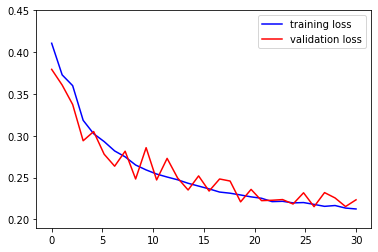

In [ ]:
x = np.linspace(0, 30, 30)
plt.plot(x, history["Train Loss"], "-b", label="training loss")
plt.plot(x, history["Validation Loss"], "-r", label="validation loss")
plt.legend(loc="upper right")
plt.ylim(0.19, 0.45)
plt.show()

Validation dice curve

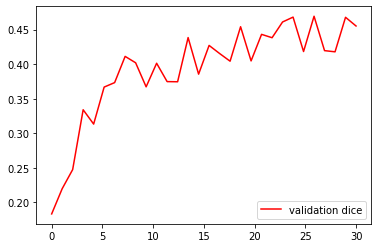

In [ ]:
x = np.linspace(0, 30, 30)

plt.plot(x, history["Validation Dice"], "-r", label="validation dice")
plt.legend(loc="lower right")
plt.show()

Load the generated model

In [ ]:
channels = 3
model = MRI_net(channels)
model.to(device)  

In [ ]:
model.load_state_dict(torch.load("drive/MyDrive/models/best_model_Simple.bin", map_location=device))

<All keys matched successfully>

In [ ]:
# summary of the generated model 
model_summary = summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
         MaxPool2d-2         [-1, 64, 112, 112]               0
              ReLU-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
         MaxPool2d-5          [-1, 128, 56, 56]               0
            Conv2d-6          [-1, 256, 56, 56]         295,168
         MaxPool2d-7          [-1, 256, 28, 28]               0
            Conv2d-8          [-1, 512, 28, 28]       1,180,160
         MaxPool2d-9          [-1, 512, 14, 14]               0
          Encoder-10          [-1, 512, 14, 14]               0
  ConvTranspose2d-11          [-1, 256, 28, 28]         524,544
  ConvTranspose2d-12          [-1, 128, 56, 56]         131,200
  ConvTranspose2d-13         [-1, 64, 112, 112]          32,832
  ConvTranspose2d-14          [-1, 3, 2

Plot an image matrix, with the following columns

*   First column: original image with the original mask
*   Second column: original image with the predicted mask
*   Third column: original image with the difference between the original mask and the predicted mask




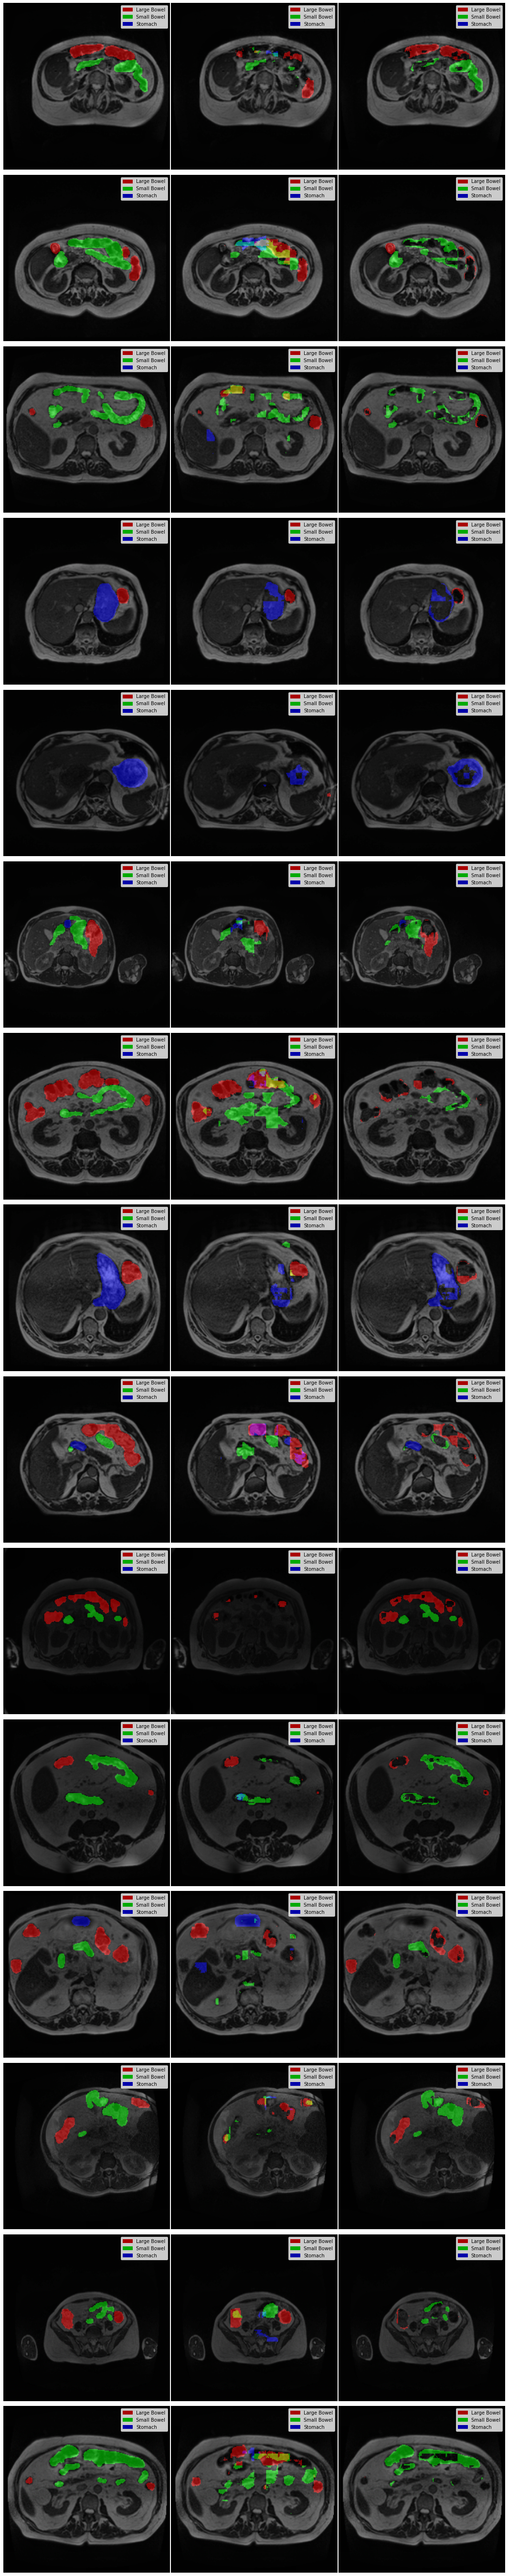

In [ ]:
df_test = pd.read_csv('uw-madison-gi-tract-image-segmentation/datasets/test.csv', sep='\t')
df_test = df_test.fillna('')
test_dataset = CustomDataset(df_test, subset="test", transforms=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# take some predictions from the test set
imgs, msks =  next(iter(test_loader))
imgs = imgs.to(device, dtype=torch.float)
msks = msks.cpu().detach()
preds = []
# disable gradient computation
with torch.no_grad():
    # prediction with the generated model
    pred = model(imgs)
    pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()

# Aggregate all the masks of an image
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

def plot_batch_comparison(imgs, masks, pred_masks, size=3):
    plt.figure(figsize=(15, 5*size))
    for idx in range(size):
      # plot image + real masks (on the left)
      plt.subplot(size, 3, 1 + idx*3)
      img = imgs[idx].permute((1, 2, 0)).numpy().astype(np.uint8)
      msk = masks[idx].permute((1, 2, 0)).numpy()
      show_img(img, msk)

      # plot image + predicted masks (on the middle)
      plt.subplot(size, 3, 2 + idx*3)
      msk = pred_masks[idx].permute((1, 2, 0)).numpy()
      show_img(img, msk)

      # plot image + difference of predictions (on the right)
      sub = (masks-pred_masks)[idx].permute((1, 2, 0)).numpy()
      plt.subplot(size, 3, 3 + idx*3)
      show_img(img, sub)

    plt.tight_layout()
    plt.show()

plot_batch_comparison(imgs, msks, preds, size=15)